this is copied from `20190819-04-DeepTaylor-trainMore-inplace`

In [1]:
from __future__ import print_function
import numpy as np
import torch 
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

def geometricPad(grid, pad=1):
  M = grid.shape[2]; # 0:batchsize, 1:channels, 2:width, 3:height
  M_new = pad+M+pad;
  new_shape = (grid.shape[0], grid.shape[1], M_new, M_new)
  grid_new = grid.new_zeros(new_shape);
  grid_new[:,:,pad:M+pad,pad:M+pad] = grid;
  grid_new[:,:,0:pad,pad:(M+pad)] = grid[:,:,:,0:pad].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),0:pad] = grid[:,:,0:pad,:].flip(-2).transpose(-1,-2);
  grid_new[:,:,(M+pad):(M+pad+pad),(pad):(M+pad)] = grid[:,:,:,(M-pad):].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),(M+pad):(M+pad+pad)] = grid[:,:,(M-pad):,:].flip(-2).transpose(-1,-2);
  return(grid_new);



In [2]:
class Taylorizer:
    """Perform taylor expansion of tensor using pre-computed expansion weights"""
    def __init__(self, mGridPmt, mGridCoord, pad=1, Lambda=0.5):
        """
        mGridPmt:   numpy array with (Height,Width) only significance is
                    1. value should be unique for each grid site
                    2. if no PMT exists, set to -1
        mGridCoord: numpy array with (Ncoords,Height,Width)
        pad:        the taylor expansion will be performed on a grid with sides 2*pad+1
        Lambda:     the regularization strength. should be something of order the differences in mGridCoord
        """
        
        self.mGridPmt   = mGridPmt
        self.mGridCoord = mGridCoord
        self.pad = pad
        self.Lambda = Lambda
        self.AA = self.computeTaylorWeights()
    
    def cuda(self):
        self.AA = self.AA.cuda()
    
    def cpu(self):
        self.AA = self.AA.cpu()
        
    def __call__(self, inputs):
        return self.taylorize(inputs)

    def computeTaylorWeights(self):
        pad = self.pad
        mGridPmt = self.mGridPmt
        mGridCoord = self.mGridCoord

        Ncoords = mGridCoord.shape[0]
        Ntaylor = 1 + Ncoords # + (Ncoords*(Ncoords+1))//2
        self.Ntaylor = Ntaylor

        M = mGridPmt.shape[0]
        mGridI = np.reshape(np.repeat(np.arange(M),M), (M,M))
        mGridJ = mGridI.transpose()

        Nshift = 2*pad+1
        dij = np.reshape(np.repeat(np.arange(-pad,pad+1),Nshift), (Nshift,Nshift));
        dis = dij.flatten()
        djs = dij.transpose().flatten();
        Nsites = dis.size;
        
        self.dis = dis
        self.djs = djs
        self.Nsites = Nsites

        mGridPmtpad = geometricPad(torch.tensor(mGridPmt).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
        mGridIpad = geometricPad(torch.tensor(mGridI).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
        mGridJpad = geometricPad(torch.tensor(mGridJ).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();

        mGridCoordPad = geometricPad(torch.tensor(mGridCoord).unsqueeze(0), pad).squeeze(0).numpy();


        mGridAA2 = np.zeros((M,M,Nshift,Nshift,Ntaylor))

        pmtI1 = mGridPmt[:,:]; # index in tank.pmt

        x      = np.zeros((Ncoords,M,M,Nsites));     # coordinates for each direction
        skip   = np.zeros((M,M,Nsites), dtype=bool); # for each direction whether we should skip or not
        processedPmtI2s = np.zeros((M,M,Nsites), dtype=int) - 1;

        for diji in range(Nsites):
            di = dis[diji]
            dj = djs[diji]
            # i2 = mGridIpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
            # j2 = mGridJpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
            pmtI2 = mGridPmtpad[(pad+di):(pad+M+di),(pad+dj):(pad+M+dj)];
            processedPmtI2s[:,:,diji] = pmtI2;

            skip[:,:,diji] = np.logical_or(np.equal(pmtI1,-1), np.equal(pmtI2,-1));
            for prev_diji in range(diji):
                skip[:,:,diji] = np.logical_or(skip[:,:,diji], np.equal(processedPmtI2s[:,:,prev_diji],pmtI2));

            x[:,:,:,diji] = mGridCoordPad[:,(pad+di):(pad+M+di),(pad+dj):(pad+M+dj)] - mGridCoord; # 

        # x: (Ncoords,M,M,Nsites)
        # print('x.shape:', x.shape)
        # X: (Ntaylor,M,M,Nsites)
        Xlist = [np.expand_dims(np.ones(x.shape[1:]),0),x]
        #for i in range(Ncoords):
        #    Xlist.append(np.stack([x[i,:,:,:] for j in range(Ncoords-i)]) * x[i:,:,:,:])
        X = np.concatenate(Xlist)
        # print('X.shape:', X.shape)
        X = np.where(np.expand_dims(skip, 0), 0., X);

        # regularization strength
        Lambda = self.Lambda; # this should be somewhat smaller than typical values of x

        MA = np.zeros((M,M,Nsites,Nsites));
        for k in range(Nsites):
            for j in range(Nsites):
                MA[:,:,k,j] = np.add(np.sum(X[:,:,:,k]*X[:,:,:,j], axis=0), Lambda**2 * (k==j));
            # clear skip entries
            MA[:,:,k,:] = np.where(np.expand_dims(skip[:,:,k],-1), 0., MA[:,:,k,:]);
            MA[:,:,:,j] = np.where(np.expand_dims(skip[:,:,j],-1), 0., MA[:,:,:,j]);
            # set diagonal:
            MA[:,:,k,k] = np.where(skip[:,:,k], 1., MA[:,:,k,k]);

        #print('MA.shape:',MA.shape)
        #print(MA[0,1,:,:])
        #print(np.linalg.inv(MA[0,1,:,:]))
        print("starting inversion... (may take a few seconds)")
        AA = np.einsum('hwsi,thwi->thws', np.linalg.inv(MA), X)
        print("done")
        # print('AA.shape:', AA.shape)
        return torch.tensor(AA, dtype=torch.float)
    
    def taylorize(self, inputs):
        Batches = inputs.shape[0]
        ChIn    = inputs.shape[1]
        Height  = inputs.shape[2]
        Width   = inputs.shape[3]
        tGridAA = self.AA

        inputsPad = geometricPad(inputs, self.pad); # (B,C,W,H)
        tayloredInput = inputs.new_zeros((Batches, self.Ntaylor, ChIn, Height, Width))
        
        #print('tGridAA.shape:', tGridAA.shape)
        #print('tayloredInput.shape:', tayloredInput.shape)
        #print('inputsPad.shape:', inputsPad.shape)
        for k in range(self.Nsites):
            # shift grid according to position (without copying the data)
            inputsPadD1 = torch.narrow(inputsPad,   2, self.pad+int(self.dis[k]), Height)
            inputsPadD2 = torch.narrow(inputsPadD1, 3, self.pad+int(self.djs[k]), Width )
            # at this point we have
            # tGridAA[:,:,:,k] = (d,i,j)   = (taylor,height,width)
            # inputsPadD2      = (b,c,i,j) = (batch,channel,height,width)
            # 
            # what we want to do is an in-place operation equivalent to
            # out = torch.add(tayloredInput, torch.einsum('dij,bcij->bdcij', tGridAA[:,:,:,k], inputsPadD2))
            # tayloredInput = out

            tGridAAk = tGridAA[:,:,:,k].unsqueeze(0).unsqueeze(2)
            inputsPadD2 = inputsPadD2.unsqueeze(1)
            # now we have
            # tGridAAk    = ( ,d, ,i,j)
            # inputsPadD2 = (b, ,c,i,j)
            # so we can realize torch.einsum('dij,bcij->bdcij') with broadcasting

            # perform in-place addition
            tayloredInput.addcmul_(1., tGridAAk, inputsPadD2)
        
        # contract the taylor*channel dimension
        return tayloredInput.view(Batches, self.Ntaylor*ChIn, Height, Width)
    
    def pool2d(self, kernel_size, pad=-1, Lambda=-1.):
        """
        Return new Taylorizer that can be used for the result of a 2d pool operation with given kernel size.
        kernel_size: e.g. for 2x2 max-pooling use (2,2)
        pad:    if unset (-1)  use same as current
        Lambda: if unset (-1.) use same as current
        """
        mGridPmt1   = torch.nn.functional.max_pool2d(torch.tensor(self.mGridPmt  ).to(torch.float).unsqueeze(0), kernel_size).squeeze(0).to(torch.long).numpy()
        mGridFilled1 = torch.nn.functional.avg_pool2d(torch.tensor((self.mGridPmt >= 0).astype(float)).unsqueeze(0), kernel_size).squeeze(0).numpy()
        
        mGridCoord1 = torch.nn.functional.avg_pool2d(torch.tensor(self.mGridCoord), kernel_size).numpy()
        mGridCoord1 /= mGridFilled1 # correct average for missing positions
        
        if (pad < 0):
            pad = self.pad
        if (Lambda < 0.):
            Lambda = self.Lambda
        
        return Taylorizer(mGridPmt1, mGridCoord1, pad=pad, Lambda=Lambda)

In [3]:
f = h5py.File('/home/lukasb/watchmal/data/IWCDmPMT_4pi_full_tank/h5_topo/IWCDmPMT_4pi_full_tank_e-_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_1.h5','r')
event_data = f['event_data'][:]

In [11]:
mGridPmt = f['mGridPmt'][()]
mGridCoord = np.stack([
    f['mGridX'][()]/20.,
    f['mGridY'][()]/20.,
    f['mGridZ'][()]/20.,
    f['mGridDirX'][()],
    f['mGridDirY'][()],
    f['mGridDirZ'][()]
])

taylor0 = Taylorizer(mGridPmt, mGridCoord, pad=1, Lambda=1.)

starting inversion... (may take a few seconds)
done


In [5]:
def imshowRdBu(ax,img):
    minmax = max(torch.max(img),-torch.min(img))
    return ax.imshow(-img,cmap='RdBu',vmin=-minmax,vmax=minmax)

## Train network

In [6]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 4: # pip
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        
        event_data = fh['event_data'][entry_index]
        return event_data[:,:,0:1],label,idx

def HKCollate(batch):
    data  = np.stack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    return data,label,idx

In [7]:
# also add more data

mcdir = '/home/lukasb/watchmal/data/IWCDmPMT_4pi_full_tank/h5_topo'
pnames = ('e-','mu-')
files = ['%s/%s/IWCDmPMT_4pi_full_tank_%s_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_%d.h5' % (mcdir,pname,pname,bch+100) for bch in range(30) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size= 64,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=200,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [8]:
class GeomBNConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,pad):
        super(GeomBNConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.pad = pad
        self.batchNorm2d = torch.nn.BatchNorm2d(Cin)
        self.conv2d = torch.nn.Conv2d(Cin,Cout,2*self.pad+1)
 
    def forward(self, x):
        x = self.batchNorm2d(x)
        inputsPad = geometricPad(x, self.pad); # (B,C,W,H)
        return self.conv2d(inputsPad)

class TaylorBNConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,taylor):
        super(TaylorBNConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.taylor = taylor
        self.batchNorm2d = torch.nn.BatchNorm2d(Cin*taylor.Ntaylor)
        self.conv2d = torch.nn.Conv2d(Cin*taylor.Ntaylor,Cout,1)
 
    def forward(self, x):
        x = self.taylor(x)
        x = self.batchNorm2d(x)
        x = self.conv2d(x)
        return x
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(TaylorBNConv2d, self).cpu()
        self.taylor.cpu()
        return self
    
    def cuda(self):
        super(TaylorBNConv2d, self).cuda()
        self.taylor.cuda()
        return self


class TaylorCNN(torch.nn.Module):
    
    def __init__(self, num_class, taylor):
        super(TaylorCNN, self).__init__()
        
        # prepare taylorizers for maxpool operations
        taylor1 = taylor .pool2d((2,2))
        taylor2 = taylor1.pool2d((2,2))
        #taylor3 = taylor2.pool2d((2,2))
        #taylor4 = taylor3.pool2d((2,2))
        
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # taylor conv
            TaylorBNConv2d( 1,16,taylor), torch.nn.ReLU(),
            TaylorBNConv2d(16,32,taylor), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorBNConv2d(32,32,taylor1), torch.nn.ReLU(),
            TaylorBNConv2d(32,32,taylor1), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorBNConv2d(32,64,taylor2), torch.nn.ReLU(),
            TaylorBNConv2d(64,64,taylor2), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            GeomBNConv2d( 64,128,1), torch.nn.ReLU(),
            GeomBNConv2d(128,128,1), torch.nn.ReLU()
        )
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,32), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(TaylorCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(TaylorCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [9]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        data = data.permute(0,3,1,2)
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            #label = torch.as_tensor(blob.label).type(torch.FloatTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())
        # mse        = blob.mse(prediction,label).cpu().detach().numpy()
        # accuracy   = np.sqrt(mse.mean()).item()
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()

def save_state(blob):
    # Output file name
    filename = '%s-%d.ckpt' % (blob.prefix, blob.iteration)
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_epoch': blob.epoch,
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(blob, iteration):
    # Open a file in read-binary mode
    weight_file = '%s-%d.ckpt' % (prefix.prefix, iteration)
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.epoch     = checkpoint['global_epoch']
        blob.iteration = checkpoint['global_step']

# weight_file = save_state(blob, '20190819-02-DeepTaylor-01-BatchNorm')
# print('Saved to', weight_file)


# # Recreate the network (i.e. initialize)
# blob.net=LeNet().cuda()
# # Get one batch of data to test
# blob.data, blob.label = next(iter(train_loader))
# # Run forward function
# res = forward(blob,True)
# # Report
# print('Accuracy:',res['accuracy'])



# # Restore the state
# restore_state(weight_file,blob)
# # Run the forward function
# res = forward(blob,True)
# # Report
# print('Accuracy',res['accuracy'])

In [12]:
class BLOB:
    pass
blob=BLOB()
blob.net       = TaylorCNN(2, taylor0).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.prefix    = '20200629-02-IWCD-DeepTaylor-01-TaylorCNN'
blob.epoch     = 0.
blob.iteration = 0
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done


/usr/lib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in true_divide


it seems I get a division by 0 error. I hope this will not be a big issue...

In [ ]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('%s-log_train.csv' % blob.prefix), CSVData('%s-log_test.csv' % blob.prefix)

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=3.0
# Set the network to training mode
blob.net.train()

# Start training
while int(blob.epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(blob.epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        blob.epoch += 1./len(train_loader)
        blob.iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[blob.iteration,blob.epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (blob.iteration,blob.epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[blob.iteration,blob.epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        # even more rarely, save state
        #if (i+1)%400 == 0:
        #    with torch.no_grad():
        #        blob.net.eval()
        #        save_state(blob)
        #    blob.net.train()
        if blob.epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (blob.iteration,blob.epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2020-06-30 00:27:48


/opt/conda/conda-bld/pytorch_1591914855613/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)


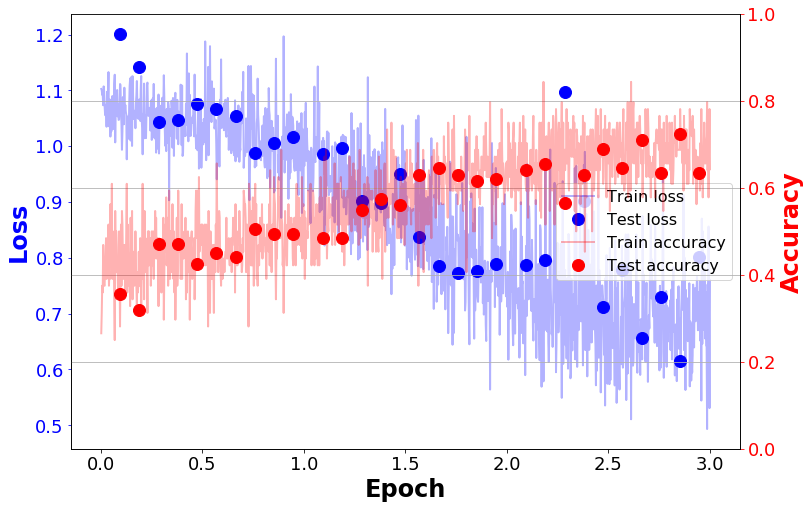

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [24]:
def inference(blob,data_loader):
    label,prediction,accuracy=[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        blob.data, blob.label = data[0:2]
        res = forward(blob,train=False)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        label.append(blob.label)
        #if i==2: break
    # report accuracy
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    
    return accuracy, label, prediction

In [25]:
from utils.utils import plot_confusion_matrix
accuracy,label,prediction = inference(blob,test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
plot_confusion_matrix(label,prediction,['e','mu','pip'])

RuntimeError: CUDA out of memory. Tried to allocate 464.00 MiB (GPU 0; 11.91 GiB total capacity; 10.86 GiB already allocated; 105.38 MiB free; 271.91 MiB cached)

In [26]:
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

<class 'torch.Tensor'> torch.Size([7])
<class 'torch.Tensor'> torch.Size([7])
<class 'torch.Tensor'> torch.Size([7])
<class 'torch.Tensor'> torch.Size([7])
<class 'torch.Tensor'> torch.Size([16, 7, 1, 1])
<class 'torch.Tensor'> torch.Size([16, 7, 1, 1])
<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([112])
<class 'torch.Tensor'> torch.Size([112])
<class 'torch.Tensor'> torch.Size([112])
<class 'torch.Tensor'> torch.Size([112])
<class 'torch.Tensor'> torch.Size([32, 112, 1, 1])
<class 'torch.Tensor'> torch.Size([32, 112, 1, 1])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([224])
<class 'torch.Tensor'> torch.Size([224])
<class 'torch.Tensor'> torch.Size([224])
<class 'torch.Tensor'> torch.Size([224])
<class 'torch.Tensor'> torch.Size([32, 224, 1, 1])
<class 'torch.Tensor'> torch.Size([32, 224, 1, 1])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.

<class 'torch.nn.parameter.Parameter'> torch.Size([224])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([32, 112, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([112])
<class 'torch.nn.parameter.Parameter'> torch.Size([112])
<class 'torch.nn.parameter.Parameter'> torch.Size([16])
<class 'torch.nn.parameter.Parameter'> torch.Size([16, 7, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([7])
<class 'torch.nn.parameter.Parameter'> torch.Size([7])
<class 'torch.Tensor'> torch.Size([7, 52, 52, 9])
<class 'torch.Tensor'> torch.Size([7, 26, 26, 9])
<class 'torch.Tensor'> torch.Size([7])
<class 'torch.Tensor'> torch.Size([7])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([112])
<class 'torch.Tensor'> torch.Size([112])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([224])
<class 'torch.Tensor'> torch.Size([224])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tenso

/opt/conda/lib/python3.6/site-packages/torch/distributed/distributed_c10d.py:86: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "
/opt/conda/lib/python3.6/importlib/__init__.py:126: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  return _bootstrap._gcd_import(name[level:], package, level)


In [ ]:
with torch.no_grad():
    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    
    data = torch.as_tensor(blob.data).cuda()
    data = data.permute(0,3,1,2)
    # prediction = blob.net(data)
    
    ev=1
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    im = ax0.imshow(data[ev,0,:,:].cpu())
    cbar = ax0.figure.colorbar(im, ax=ax0)
    plt.show()
    
    x = data
    for i,module in enumerate(blob.net._feature):
        print('_feature', i, module)
        
        if hasattr(module, 'taylor'):
            print('taylor inputs:')
            tx = module.taylor(x)
            fig, axes = plt.subplots(1, 7, figsize=(16,3),facecolor='w')
            for i in range(7):
                im = imshowRdBu(axes[i], tx[ev,i*x.shape[1],:,:].cpu())
                cbar = axes[i].figure.colorbar(im, ax=axes[i])
            plt.show()
            print('module output:')
        
        x = module(x)
        fig, axes = plt.subplots(1, 5, figsize=(16,3),facecolor='w')
        for i in range(5):
            im = imshowRdBu(axes[i], x[ev,i,:,:].cpu())
            cbar = axes[i].figure.colorbar(im, ax=axes[i])
        plt.show()
    
    # next the classifier
    print(x.shape, 'after _feature')
    x = torch.nn.AvgPool2d(x.size()[2:])(x)
    print(x.shape, 'after AvgPool2d')
    x = x.view(-1,128)
    print(x.shape, 'after view')
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
    plt.show()
    
    for i,module in enumerate(blob.net._classifier):
        print('_classifier', i, module)
        x = module(x)
        fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
        plt.show()